### Extreme Event Case Study: October 2007 Santa Ana winds + wildfire

In [1]:
# imports
import boto3
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import sys  # Used for progress bar
from case_study_eval_utils import *
from figure_utils import *
import datetime
import sys
import os

# Import qaqc stage plot functions
sys.path.append(os.path.abspath("../scripts/3_qaqc_data"))
from qaqc_plot import flagged_timeseries_plot, _plot_format_helper, id_flag


# Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# Set relative paths to other folders and objects in repository.
BUCKET_NAME = "wecc-historical-wx"
QAQC_DIR = "3_qaqc_wx"
MERGE_DIR = "4_merge_wx"
stations_csv_path = f"s3://{BUCKET_NAME}/{QAQC_DIR}/all_network_stationlist_qaqc.csv"

## Setup

In [3]:

# read in merge station list
stn_list = pd.read_csv(
    "s3://wecc-historical-wx/4_merge_wx/all_network_stationlist_merge.csv"
)

In [5]:
# convert it into geodataframe
stns_gdf = gpd.GeoDataFrame(
    stn_list,
    geometry=gpd.points_from_xy(stn_list.longitude, stn_list.latitude, crs="EPSG:4326"),
)

In [6]:
# read in IOU service territories shapefile

# read in  CA county boundaries shapefile
service_territories = gpd.read_file(
    "../../skillshare_demo/California_Natural_Gas_Service_Area-shp"
)
service_territories = service_territories.to_crs(stns_gdf.crs)  # Convert to station CRS

In [26]:
def get_station_map(station_list: str, shapefile: str, IOU) -> None:
    """
    Generates and exports a map of station locations from the station list of the input phase.

    Parameters
    ----------
    phase: str
        the pipeline phase - "pull", "clean", "qaqc" or "merge"
    shapepath: string
        path to shapefile ofr 2021 US state borders

    Returns
    -------
    None

    """
    # if phase not in ["pull", "clean", "qaqc", "merge"]:
    #     print(f"invalid phase:{phase}")
    #     return None

    # ## Get station list
    # directory = phase_dict[phase]
    # station_list = pd.read_csv(
    #     f"s3://{BUCKET_NAME}/{directory}/all_network_stationlist_{phase}.csv"
    # )

    ## Get period

    # Format dates in datetime format (this gets lost in import).
    station_list["start-date"] = pd.to_datetime(station_list["start-date"], utc=True)
    station_list["end-date"] = pd.to_datetime(station_list["end-date"], utc=True)

    # Make a geodataframe.
    gdf = gpd.GeoDataFrame(
        station_list,
        geometry=gpd.points_from_xy(station_list.longitude, station_list.latitude),
    )
    gdf.set_crs(epsg=4326, inplace=True)  # Set CRS

    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857)  # Web mercator

    # # Read in geometry of continental US.
    # us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    list = [IOU]
    shapefile = shapefile.loc[shapefile.ABR.isin(list) == True]

    # Use to clip stations
    shapefile = shapefile.to_crs(epsg=3857)
    gdf_us = gdf_wm.clip(shapefile)

    # Plot
    ax = gdf_us.plot(
        "network",
        figsize=(15, 15),
        alpha=1,
        markersize=3,
        legend=True,
        cmap="nipy_spectral",
    )
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

    # # Save to AWS
    # img_data = BytesIO()
    # plt.savefig(img_data, format="png")
    # img_data.seek(0)

    # bucket = s3.Bucket(BUCKET_NAME)
    # export_folder = phase_dict[phase]
    # export_key = f"{export_folder}/{phase}_station_map.png"
    # bucket.put_object(
    #     Body=img_data,
    #     ContentType="image/png",
    #     Key=export_key,
    # )

    return None

## PG&E

### Filter stations

In [13]:
# define the event geometry - we'll focus on one county for now (San Diego - where the largest fires occurred)
pge_geom = service_territories[
    service_territories["ABR"] == ("PG&E")
]

In [ ]:
# filter down to stations that are in the target service territory
stns_gdf["intersects"] = stns_gdf.intersects(
    pge_geom.unary_union
)  # See which stations intersect with the target polygon

In [18]:
pge_stns = stns_gdf[stns_gdf["intersects"] == True].reset_index(
    drop=True
)  # Get just those stations, drop the others

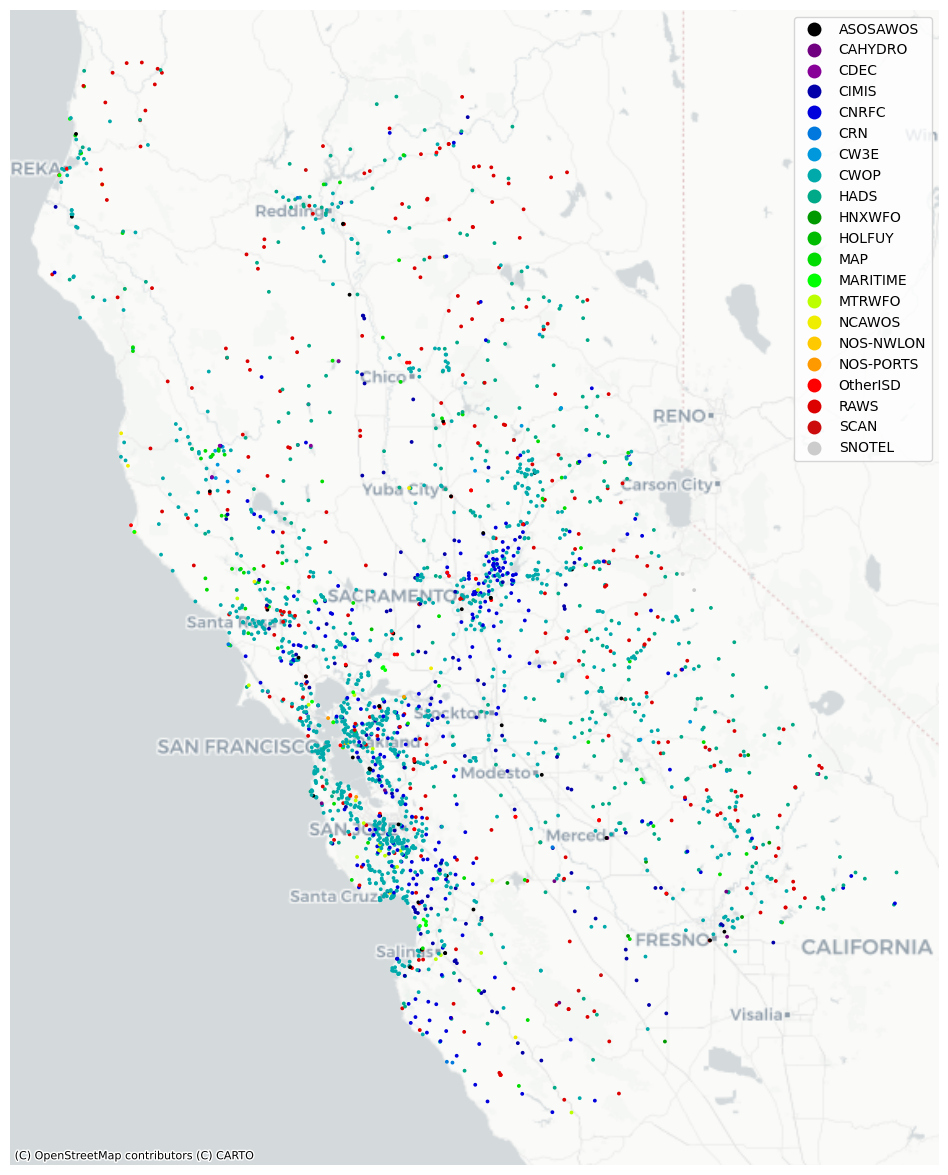

In [27]:
get_station_map(stn_list, service_territories, 'PG&E')

### Count of stations in territory

In [32]:
len(pge_stns)

2346

## SDG&E

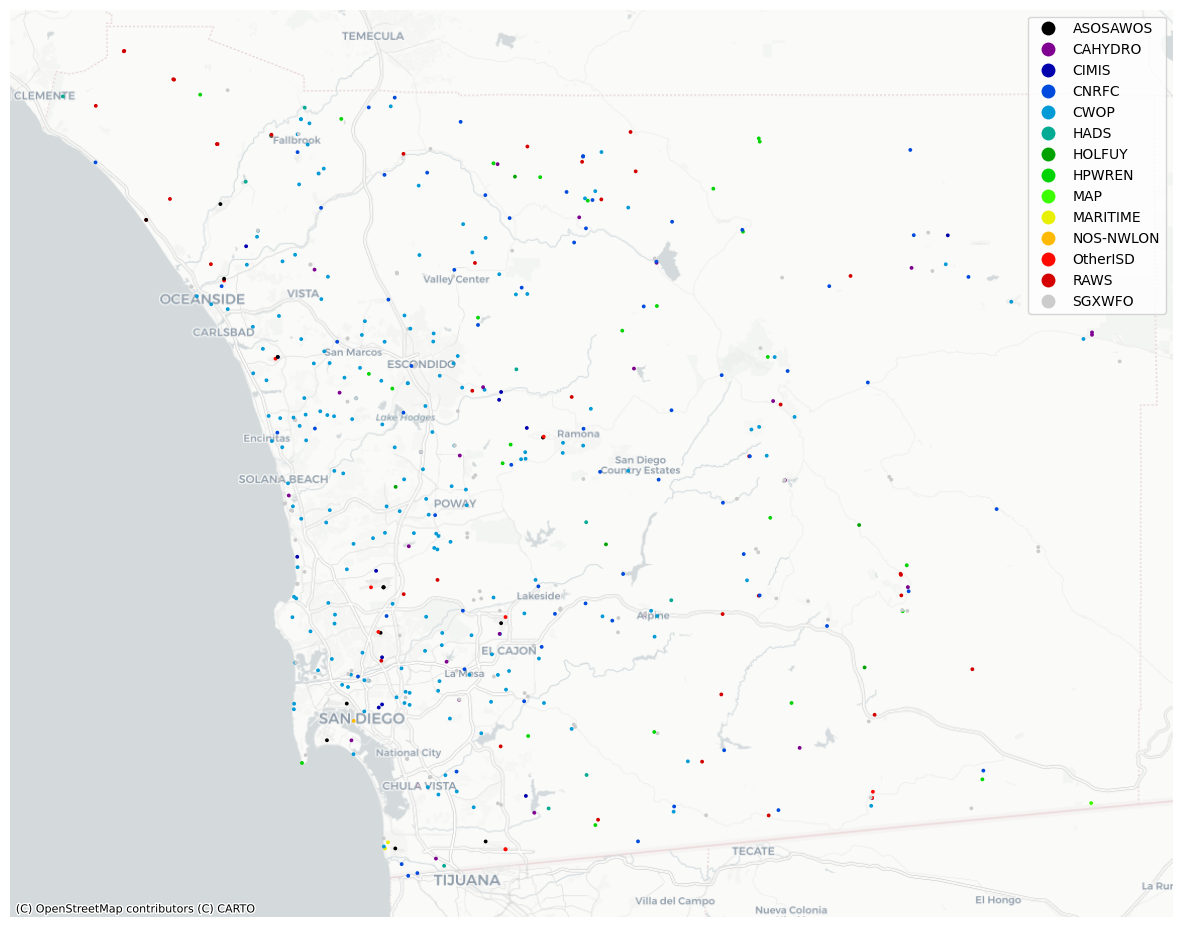

In [28]:
get_station_map(stn_list, service_territories, "SDG&E")

## SoCalGas

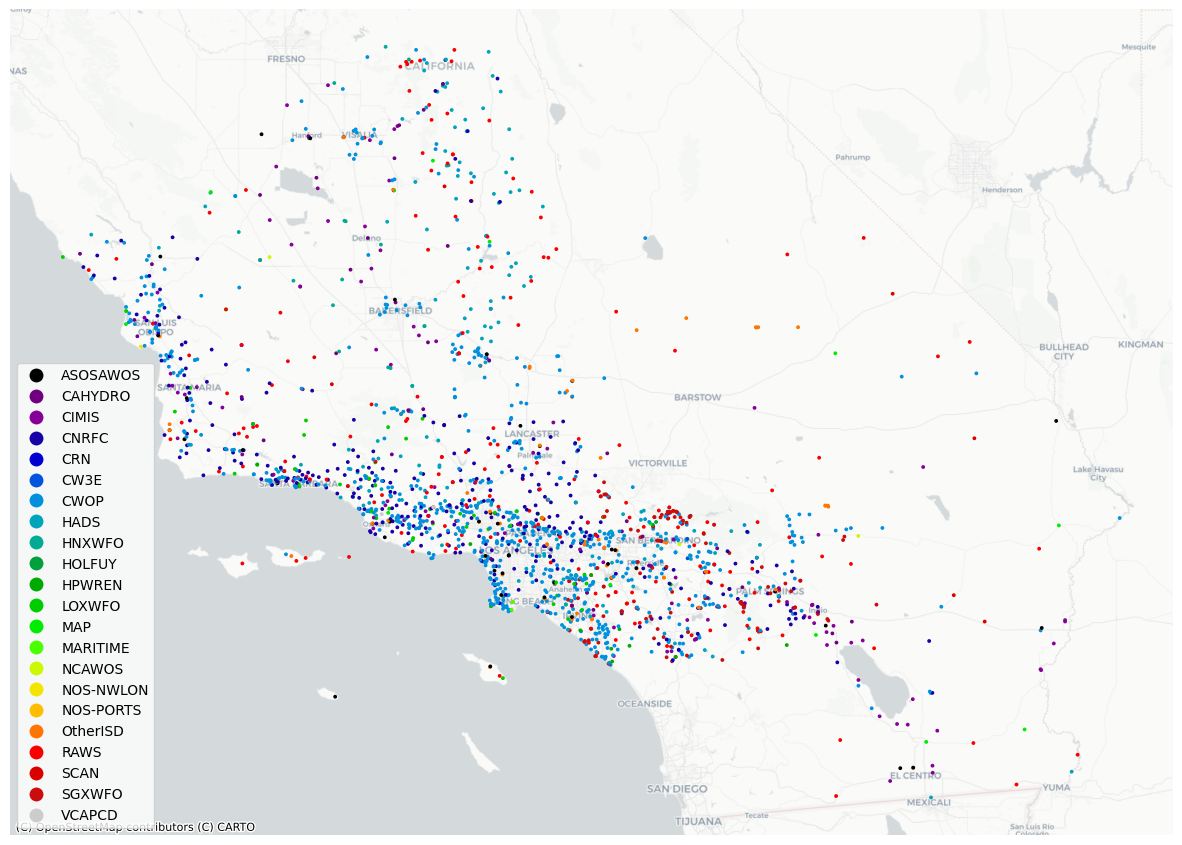

In [30]:
get_station_map(stn_list, service_territories, "SCG")

# 